# ULMFit

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_12a import *

## Data

In [3]:
path = datasets.untar_data(datasets.URLs.IMDB)

In [4]:
path

PosixPath('/home/fabiograetz/.fastai/data/imdb')

In [5]:
ll = pickle.load(open(path/'ll_lm.pkl', 'rb'))

In [6]:
bs, bptt = 64, 70

In [7]:
data = lm_databunchify(ll, bs, bptt)

In [8]:
vocab = ll.train.proc_x[1].vocab

## Finetuing the LM

In [9]:
dps = tensor([0.1, 0.15, 0.25, 0.02, 0.2]) * 0.5

In [10]:
tok_pad = vocab.index(PAD)

In [11]:
emb_sz, nh, nl = 300, 300, 2

In [12]:
model = get_language_model(len(vocab), emb_sz, nh, nl, tok_pad, *dps)

In [13]:
old_wgts = torch.load(path/'pretrained'/'pretrained.pth')

In [14]:
old_vocab = pickle.load(open(path/'pretrained'/'vocab.pkl', 'rb'))

The ids in the vocab depend on the token frequency in the corpus. We have to match the new (IMDB) vocab to the old (WT103) corpus.

In [15]:
idx_house_new, idx_house_old = vocab.index('house'), old_vocab.index('house')

In [16]:
idx_house_new, idx_house_old

(348, 231)

We have to match the embedding and the decoder weights accordingly. For tokens that did not exist in the old vocabulary and, thus, in the embedding, we use the mean of the pretrained embedding weights/decoder bias.

In [17]:
house_wgt = old_wgts['0.emb.weight'][idx_house_old]
house_bias= old_wgts['1.decoder.bias'][idx_house_old]

In [18]:
house_wgt.shape, house_bias

(torch.Size([300]), tensor(-6.5101, device='cuda:0'))

In [19]:
old_wgts['0.emb.weight'].shape, old_wgts['1.decoder.bias'].shape

(torch.Size([60001, 300]), torch.Size([60001]))

In [20]:
def match_embeds(old_wgts, old_vocab, new_vocab):
    wgts = old_wgts['0.emb.weight']
    bias = old_wgts['1.decoder.bias']
    wgts_m, bias_m = wgts.mean(dim=0), bias.mean()

    new_wgts = wgts.new_zeros(len(new_vocab), wgts.size(1))
    new_bias = bias.new_zeros(len(vocab))
    
    otoi = {v:k for k,v in enumerate(old_vocab)}
    
    for i, w in enumerate(new_vocab):
        if w in otoi:
            idx = otoi[w]  # old idx
            new_wgts[i], new_bias[i] = wgts[idx], bias[idx]
        else:
            new_wgts[i], new_bias[i] = wgts_m, bias_m
        
    old_wgts['0.emb.weight'] = new_wgts
    old_wgts['0.emb_dp.emb.weight'] = new_wgts
    old_wgts['1.decoder.weight']    = new_wgts  # weight tying
    old_wgts['1.decoder.bias']      = new_bias
    
    return old_wgts

In [21]:
wgts = match_embeds(old_wgts, old_vocab, vocab)

Let's check that the token "house" was properly converted:

In [22]:
test_near(wgts['0.emb.weight'][idx_house_new], house_wgt)

In [23]:
test_near(wgts['1.decoder.bias'][idx_house_new], house_bias)

Load pretrained weights into our model

In [24]:
model.load_state_dict(wgts);

In [25]:
model

SequentialRNN(
  (0): AWD_LSTM(
    (emb): Embedding(60002, 300, padding_idx=1)
    (emb_dp): EmbeddingDropout(
      (emb): Embedding(60002, 300, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(300, 300, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(300, 300, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (output_dp): RNNDropout()
    (decoder): Linear(in_features=300, out_features=60002, bias=True)
  )
)

We want to apply discriminative learning rates. In order to do so, we have to split our model in different layer groups:

We split the rnn/corresponding dropouts into two groups plus one additional group for the embeddings/decoder. The latter has to be trained the most because of the new embedding vectors.

In [26]:
def lm_splitter(m):
    groups = []
    for i in range(len(m[0].rnns)):
        groups.append(nn.Sequential(m[0].rnns[i], m[0].hidden_dps[i]))
    groups += [nn.Sequential(m[0].emb, m[0].emb_dp, m[0].input_dp, m[1])]

    return [list(o.parameters()) for o in groups]

First, we freeze the RNNs:

In [27]:
for rnn in model[0].rnns:
    for p in rnn.parameters():
        p.requires_grad_(False)

In [28]:
cbs = [partial(AvgStatsCallback, accuracy_flat),
       CudaCallback, Recorder,
       partial(GradientClipping, clip=0.1),
       partial(RNNTrainer, alpha=2., beta=1.),
       ProgressCallback]

In [29]:
learn = Learner(model, data, cross_entropy_flat, opt_func=adam_opt(), cb_funcs=cbs, splitter=lm_splitter)

In [30]:
lr = 2e-2

In [187]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [32]:
cbsched = sched_1cycle([lr], pct_start=0.5, mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [ ]:
learn.fit(1, cbs=cbsched)

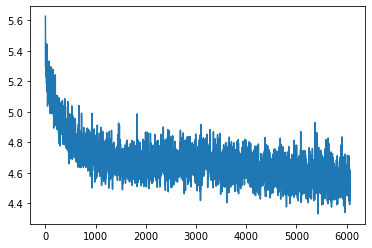

In [37]:
learn.recorder.plot_loss()

Then the entire model with discriminative learning rates:

In [38]:
for rnn in model[0].rnns:
    for p in rnn.parameters():
        p.requires_grad_(True)

In [39]:
lr = 2e-3

In [40]:
cbsched = sched_1cycle([lr/2., lr/2., lr], pct_start=0.5, mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [41]:
learn.fit(10, cbs=cbsched)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.394669,0.250716,4.317773,0.260431,14:58
1,4.326853,0.257467,4.271071,0.265299,14:57
2,4.269067,0.263070,4.229544,0.269338,14:55
3,4.219788,0.267743,4.194589,0.272833,14:57
4,4.178052,0.271664,4.166258,0.275681,14:55
5,4.144542,0.274591,4.143349,0.277895,14:57
6,4.114541,0.277206,4.124201,0.279645,14:57
7,4.088627,0.279393,4.109105,0.281351,14:57
8,4.070786,0.280875,4.101879,0.282110,14:57
9,4.061327,0.281740,4.100467,0.282265,14:56


We save the encoder and the vocab for classification.

In [42]:
torch.save(learn.model[0].state_dict(), path/'finetuned_enc.pth')

In [43]:
pickle.dump(vocab, open(path/'vocab_lm.pkl', 'wb'))

In [44]:
torch.save(learn.model.state_dict(), path/'finetuned.pth')

## Classifier

In [26]:
vocab = pickle.load(open(path/'vocab_lm.pkl', 'rb'))

In [27]:
len(vocab)

60002

In [35]:
proc_tok, proc_num, proc_cat = TokenizeProcessor(), NumericalizeProcessor(vocab=vocab), CategoryProcessor()

In [36]:
il = TextList.from_files(path, include=['train', 'test'])

In [37]:
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='test'))

In [56]:
ll = label_by_func(sd, parent_labeler, proc_x = [proc_tok, proc_num], proc_y=proc_cat)

In [57]:
pickle.dump(ll, open(path/'ll_clas.pkl', 'wb'))

In [28]:
ll = pickle.load(open(path/'ll_clas.pkl', 'rb'))

In [29]:
bs, bptt = 64, 70

In [30]:
data = clas_databunchify(ll, bs)

### Ignore padding of the inputs

In [46]:
#export
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [47]:
gen = iter(data.train_dl)

In [48]:
x, y = next(gen)

In [49]:
x.shape, y.shape

(torch.Size([64, 3352]), torch.Size([64]))

The utility functions need the lengths of the sequences as they are applied after the embedding (and the padding can't be seen anymore).

In [50]:
lengths = x.size(1) - (x == 1).sum(1)

In [51]:
lengths[:10]

tensor([3352, 1741, 1558, 1528, 1444, 1348, 1335, 1326, 1316, 1313])

In [52]:
test_emb = nn.Embedding(len(vocab), 300)

In [53]:
test_emb(x).shape

torch.Size([64, 3352, 300])

This tensor is padded, however!

Let's create a `PackedSequence` object that contains all of our *unpadded* sequences:

In [142]:
packed = pack_padded_sequence(test_emb(x), lengths, batch_first=True)

In [154]:
packed;

In [146]:
packed.data.shape

torch.Size([29935, 300])

**Explaining the "29935":**

In [190]:
lengths.sum()

tensor(29935)

The padding is simply left out.

**Explaining the `packed.batch_sizes`:**

The longest sequence is 479 long, we have that many batch sizes:

In [155]:
len(packed.batch_sizes)

479

In [163]:
packed.batch_sizes[:4]

tensor([64, 64, 64, 64])

In the first few steps, all sequences are long enough and "still left".

In [157]:
packed.batch_sizes[-4:]

tensor([13, 10,  6,  2])

In [152]:
lengths[:15]

tensor([479, 479, 478, 478, 478, 478, 477, 477, 477, 477, 476, 476, 476, 475,
        474])

There are 2 sequences with 479 tokens. These remain until the last step. There are 6 sequences that have >= 478 tokens. There are 10 sequences with >= 477 tokens. There are 13 sequences with >= 476 tokens.

The `packed.batch_sizes` tensor says "how many sequences are left at a certain length". In the beginning all 64 sequences are long enough. But later only a few sequences are left, on the last step only 2 are left.

**The `packed` object can be passed to any RNN directly while preserving the speed of CuDNN without wasting compute on padding.**

In [224]:
test_lstm = nn.LSTM(300, 500, 4)  # input_sz, hidden_sz, n_layers

In [225]:
y, h = test_lstm(packed)

Last hidden state:

In [231]:
len(h)  # hidden and cell state

2

In [230]:
h[1].shape  # num_layers, bs, and hidden_size

torch.Size([4, 64, 500])

**Pad the packed sequence:**

In [221]:
unpacked = pad_packed_sequence(y, batch_first=True)

In [232]:
len(unpacked)

2

In [234]:
unpacked[0].shape  # the padded tensor of hidden states

torch.Size([64, 479, 500])

In [223]:
(unpacked[1] == lengths).all()  # contains the lengths

tensor(1, dtype=torch.uint8)

**Let's adapt the AWD-LSTM accordingly:**

In [38]:
#export
class AWD_LSTM1(nn.Module):
    "AWD-LSTM inspired by https://arxiv.org/abs/1708.02182."
    initrange=0.1

    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token,
                 hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5):
        super().__init__()
        self.bs, self.emb_sz, self.n_hid, self.n_layers, self.pad_token = 1, emb_sz, n_hid, n_layers, pad_token  # bs = 1 to make it reset h
        self.emb = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.emb_dp = EmbeddingDropout(self.emb, embed_p)
        self.rnns = [nn.LSTM(input_size=emb_sz if l == 0 else n_hid, 
                             hidden_size=(n_hid if l != n_layers - 1 else emb_sz),
                             num_layers=1, batch_first=True
                            ) for l in range(n_layers)]
        """
        (Pdb) self.rnns[0]
        LSTM(300, 500, batch_first=True)
        (Pdb) self.rnns[1]
        LSTM(500, 500, batch_first=True)
        (Pdb) self.rnns[2]
        LSTM(500, 300, batch_first=True)
        (Pdb) self.rnns[3]
        """
        self.rnns = nn.ModuleList([WeightDropout(rnn, weight_p) for rnn in self.rnns])
        # Initialize embedding
        self.emb.weight.data.uniform_(-self.initrange, self.initrange)
        
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input):
        bs, sl = input.size()
        mask = (input == self.pad_token)
        lengths = sl - mask.long().sum(1)
        n_empty = (lengths == 0).sum()
        
        if n_empty > 0:
            input = input[:-n_empty]
            lengths = lengths[:-n_empty]
            self.hidden = [(h[0][:,:input.size(0)], h[1][:,:input.size(0)]) for h in self.hidden]

        # self.hidden ist list of len 3 of tuples of len 2 of tensors of shape [1, 64, 500/300]
        # input shape [64, 70]
        raw_output = self.input_dp(self.emb_dp(input))  # [64, 70, 300], dropout on input along seq dimension
        
        new_hidden,raw_outputs,outputs = [],[],[]

        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output = pack_padded_sequence(raw_output, lengths, batch_first=True)
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            raw_output = pad_packed_sequence(raw_output, batch_first=True)[0]
            # new_h has shape [1, 64, 500] for l = 0 (final hidden state), raw_output [64, 70, 500] for l == 0

            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)  # RNNDropout along seq dim on h's
            outputs.append(raw_output)
            new_hidden.append(new_h)
             
        # here new_hidden is list of len n_layers with tuples of two tensors h,c each
        self.hidden = to_detach(new_hidden)
        return raw_outputs, outputs, mask  # with and without dropout

    def _one_hidden(self, l):
        "Return one hidden state."
        nh = self.n_hid if l != self.n_layers - 1 else self.emb_sz
        return next(self.parameters()).new(1, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

In [39]:
test_input = torch.randint(low=0, high=30000, size=(64, 70)) # (bs, seq_len)

In [40]:
awd_lstm = AWD_LSTM1(30000, 300, 500, 3, vocab.index(PAD))

In [41]:
awd_lstm.bs = bs

In [42]:
awd_lstm.reset()

In [43]:
raw_outputs, outputs, mask = awd_lstm(test_input)

In [44]:
len(outputs), outputs[-1].shape, mask.shape, mask[:,:,None].shape

(3, torch.Size([64, 70, 300]), torch.Size([64, 70]), torch.Size([64, 70, 1]))

### Concat pooling
For the classification head of the model we will use the last hidden state, the average of all hidden states, and the maximum of all the hidden states. The trick os to, once again, ignore the padding in the last element/average/maximum.

In [54]:
lengths[:,None].shape

torch.Size([64, 1])

In [55]:
class Pooling(nn.Module):
    def forward(self, input):
        raw_outputs, outputs, mask = input
        output = outputs[-1]
        lengths = output.size(1) - mask.long().sum(dim=1)
        
        avg_pool = output.masked_fill(mask[:,:,None], 0).sum(dim=1)  # replace padded parts with 0
        avg_pool.div_(lengths.type(avg_pool.dtype)[:,None])
        # shape [64, 300]
        
        max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
        
        x = torch.cat([
            output[torch.arange(0, output.size(0)), lengths - 1],  # last hidden state before padding
            max_pool,
            avg_pool
        ], 1)
        
        # shape [64, 900]

        return output, x

In [56]:
emb_sz, nh, nl = 300, 500, 2
tok_pad = vocab.index(PAD)

In [57]:
enc = AWD_LSTM1(len(vocab), emb_sz, n_hid=nh, n_layers=nl, pad_token=tok_pad)

In [58]:
pool = Pooling()

In [59]:
enc.bs = bs
enc.reset()

In [60]:
x, y = next(iter(data.train_dl))

In [61]:
output, c = pool(enc(x))

In [62]:
output.shape, c.shape

(torch.Size([64, 3352, 300]), torch.Size([64, 900]))

In [63]:
x

tensor([[    2,     7,  1145,  ..., 15375,    24,     3],
        [    2,   194,    50,  ...,     1,     1,     1],
        [    2,     7,    47,  ...,     1,     1,     1],
        ...,
        [    2,     7,    28,  ...,     1,     1,     1],
        [    2,     7,   361,  ...,     1,     1,     1],
        [    2,     7,    17,  ...,     1,     1,     1]])

All sequences have padding except the first one which is the longest. When unpacking/padding the packed sequence, PyTorch puts 0s everywhere we had padding:

In [64]:
output.shape

torch.Size([64, 3352, 300])

In [65]:
output.sum(dim=2) == 0

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.uint8)

In [66]:
test_near((output.sum(dim=2) == 0).float(), (x ==tok_pad).float())

So the last hidden state for each sequence is generally not the last element of `output`!

In [67]:
x.size()

torch.Size([64, 3352])

In [71]:
output.shape

torch.Size([64, 3352, 300])

In [72]:
c.shape

torch.Size([64, 900])

In [78]:
for i in range(bs):
    length = x.size(1) - (x[i] == 1).long().sum()
    out_unpad = output[i,:length]
    test_near(out_unpad[-1], c[i,:300])
    test_near(out_unpad.max(0)[0], c[i,300:600])
    test_near(out_unpad.mean(0), c[i,600:])

The pooling layer properly ignores the padding. Let's feed the output into a classifier:

In [150]:
def bn_drop_lin(n_in, n_out, bn=True, p=0., actn=None):
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p !=0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [154]:
class PoolingLinearClassifier(nn.Module):
    def __init__(self, layers, drops):
        super().__init__()
        mod_layers = []
        activs = [nn.ReLU(inplace=True)] * (len(layers) - 2) + [None]
        for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], drops, activs):
            mod_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)

        self.layers = nn.Sequential(*mod_layers)
        
    def forward(self, input):
        raw_outputs, outputs, mask = input
        output = outputs[-1]
        lengths = output.size(1) - mask.long().sum(dim=1)
        
        avg_pool = output.masked_fill(mask[:,:,None], 0).sum(dim=1)  # replace padded parts with 0
        avg_pool.div_(lengths.type(avg_pool.dtype)[:,None])          # shape [64, 300]
        max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
        
        x = torch.cat([
            output[torch.arange(0, output.size(0)), lengths - 1],  # last hidden state before padding
            max_pool,
            avg_pool
        ], 1) # shape [64, 900]
        
        x = self.layers(x)
        return x

We cannot pass the entire texts to the AWD_LSTM or we might get OOM error. We have to cut them into chunks of lengths bptt to regularly detach the history of our hidden states.

In [81]:
??SequentialRNN

In [82]:
def pad_tensor(t, bs, val=0.):
    if t.size(0) < bs:
        return torch.cat([t, val + t.new_zeros(bs-t.size(0), *t.shape[1:])])
    return t

In [130]:
class SentenceEncoder(nn.Module):
    def __init__(self, module, bptt, pad_idx=1):
        super().__init__()
        self.bptt, self.module, self.pad_idx = bptt, module, pad_idx
        
    def concat(self, arrs, bs):
        return [torch.cat([pad_tensor(l[si], bs) for l in arrs], dim=1) for si in range(len(arrs[0]))]
    
    def forward(self, input):
        bs, sl = input.size()
        self.module.bs = bs
        self.module.reset()
        raw_outputs, outputs, masks = [], [], []
        
        for i in range(0, sl, self.bptt):
            r, o, m = self.module(input[:, i: min(i+self.bptt, sl)])
            masks.append(pad_tensor(m, bs, 1))
            raw_outputs.append(r)
            outputs.append(o)

        # outputs is a list of lengths #chunks of lists of length n_layers of tensors of shape [bs, bptt, 500/300]
        # self.concat returns a list of length n_layers of tensors of shape [bs, length of entire document, 500/300]
        return self.concat(raw_outputs, bs), self.concat(outputs, bs), torch.cat(masks, dim=1)

In [131]:
x.shape

torch.Size([64, 3352])

In [132]:
s = SentenceEncoder(enc, 70)

In [133]:
r, o, m = s(x)

In [142]:
len(r), len(o)

(2, 2)

In [138]:
r[0].shape, o[0].shape, m.shape

(torch.Size([64, 3352, 500]),
 torch.Size([64, 3352, 500]),
 torch.Size([64, 3352]))

In [140]:
(r[1] == o[1]).all()

tensor(1, dtype=torch.uint8)

In [141]:
(r[0] == o[0]).all()

tensor(0, dtype=torch.uint8)

In [159]:
def get_text_classifier(vocab_sz, emb_sz, n_hid, n_layers, n_out, pad_token, bptt, output_p=0.4, hidden_p=0.2, 
                        input_p=0.6, embed_p=0.1, weight_p=0.5, layers=None, drops=None):
    rnn_enc = AWD_LSTM1(vocab_sz, emb_sz, n_hid=n_hid, n_layers=n_layers, pad_token=pad_token,
                        hidden_p=hidden_p, input_p=input_p, embed_p=embed_p, weight_p=weight_p)
    
    enc = SentenceEncoder(rnn_enc, bptt)
    if layers is None: layers = [50]
    if drops is None: drops = [0.1] * len(layers)
    layers = [3 * emb_sz] + layers + [n_out]
    drops = [output_p] + drops

    return SequentialRNN(enc, PoolingLinearClassifier(layers, drops))

In [160]:
emb_sz, nh, nl = 300, 300, 2
dps = tensor([0.4, 0.3, 0.4, 0.05, 0.5]) * 0.25

In [161]:
model = get_text_classifier(len(vocab), emb_sz, nh, nl, 2, 1, bptt, *dps)

## Training

In [164]:
model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM1(
      (emb): Embedding(60002, 300, padding_idx=1)
      (emb_dp): EmbeddingDropout(
        (emb): Embedding(60002, 300, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(300, 300, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(300, 300, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(900, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.10000000149011612)
      (2): Linear(in_features=900, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
      (6): Linear(in_features=50, out_features

In [190]:
def class_splitter(m):
    enc = m[0].module
    groups = [nn.Sequential(enc.emb, enc.emb_dp, enc.input_dp)]
    
    for i in range(len(enc.rnns)):
        groups.append(nn.Sequential(enc.rnns[i], enc.hidden_dps[i]))
    
    groups.append(m[1])
    
    return [list(o.parameters()) for o in groups]

Freeze the model:

In [191]:
for p in model[0].parameters():
    p.requires_grad_(False)

In [192]:
cbs = [partial(AvgStatsCallback,accuracy),
       CudaCallback, Recorder,
       partial(GradientClipping, clip=0.1),
       ProgressCallback]

In [193]:
model[0].module.load_state_dict(torch.load(path/'finetuned_enc.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [194]:
learn = Learner(model, data, F.cross_entropy, opt_func=adam_opt(), cb_funcs=cbs, splitter=class_splitter)

In [195]:
lr = 1e-2

In [196]:
cbsched = sched_1cycle([lr], mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [197]:
learn.fit(1, cbs=cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.346226,0.851160,0.270373,0.886440,00:39


In [198]:
for p in model[0].parameters():
    p.requires_grad_(True)

In [199]:
lr = 1e-3

In [200]:
cbsched = sched_1cycle([lr/8., lr/4., lr/2., lr], mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [201]:
learn.fit(2, cbs=cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.282283,0.882800,0.227641,0.908600,01:00
1,0.248779,0.900240,0.228977,0.906480,01:00


In [202]:
learn.fit(5, cbs=cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.239340,0.902880,0.216996,0.912200,01:00
1,0.230223,0.908880,0.207723,0.916640,00:59
2,0.211512,0.917240,0.198096,0.920720,00:59
3,0.193093,0.924920,0.198282,0.921760,01:00
4,0.181635,0.927680,0.200793,0.920120,01:00


In [203]:
x, y = next(iter(data.valid_dl))

In [204]:
pred_batch = learn.model.eval()(x.cuda())

In [208]:
pred_ind = []
for inp in x:
    length = x.size(1) - (inp == 1).long().sum()
    inp = inp[:length]
    pred_ind.append(learn.model.eval()(inp[None].cuda()))

In [209]:
assert near(pred_batch, torch.cat(pred_ind))

Predicting on the padded batch gives the same as predicting on the individual unpadded documents!